# Predicting Product Success When Review Data Is Available
_**Using XGBoost to Predict Whether Sales will Exceed the "Hit" Threshold**_

---

---

## Novos Testes

Para termos uma validação com dados mais recentes criei um novo dataset com dados de games lançados nos últimos anos.  

Este Dataset foi gerado apartir de dados colhidos na internet inclusive no site [Metacritic](http://www.metacritic.com/browse/games/release-date/available. Os daos incluem revisão de usuários, críticos, vendas e classificações.

Este notebook focará em classificar esta lista de poucos games para determinar se o game é ou não um sucesso de vendas.

Este notebook tratará os dados colhidos colocando-os da mesma forma que os dados que foram utilizados para treinamentos e validações.

In [1]:
bucket = 'smworkshop-susana-velloso'
prefix = 'sagemaker/videogames_xgboost'
 
import sagemaker

role = sagemaker.get_execution_role()

Next we'll import the Python libraries we'll need.

In [2]:
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt   
from IPython.display import Image                 
from IPython.display import display               
from sklearn.datasets import dump_svmlight_file   
from time import gmtime, strftime                 
import sys                                        
import math                                       
import json
import boto3

---
## Data

Os dados colhidos foram colocados no arquivo Score_2022.csv que faz parte da instancia do notebook. Vamos dar uma olhada inicial nos dados.

In [3]:
data_bucket = 'sagemaker-workshop-pdx'

data_teste = pd.read_csv('./Score_2022.csv')
pd.set_option('display.max_rows', 20) 
data_teste

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Elden Ring,PS5,2022,Action,Bandai Namco Entertainment,0,0,0,0,13.4,96,83,7.6,8926,From Software,M
1,LEGO Star Wars: The Skywalker Saga,XB,2022,Adventure,Warner Bros. Interactive,0,0,0,0,0.0,82,51,8.4,71,TT Games,E10+
2,Pokemon Legends: Arceus*,Switch,2022,Role-Playing,Nintendo,0,0,0,0,0.0,83,116,8.2,3307,Game Freak,E
3,Horizon II: Forbidden West,PS5,2022,Adventure,Sony (Corp),0,0,0,0,0.0,88,125,8.0,8722,Guerrilla,T
4,MLB: The Show 22,XB,2022,Sports,Multiple Video Game Manufacturers,0,0,0,0,0.0,80,15,5.5,22,Sony Interactive Entertainment San Diego Studio,E
5,Gran Turismo 7,PS5,2022,Racing,Sony (Corp),0,0,0,0,0.0,87,119,2.0,10545,PolyPhony Digital,E
6,Call of Duty: Vanguard,PS5,2021,Action,Activision Blizzard (Corp),0,0,0,0,0.0,73,68,3.5,1332,Sledgehammer Games,M
7,Kirby and the Forgotten Land*,Switch,2022,Action,Nintendo,0,0,0,0,0.0,85,128,8.8,503,Nintendo,E10+
8,Madden NFL 22,XB,2021,Sports,Electronic Arts,0,0,0,0,0.0,70,21,0.6,330,EA Tiburon,E
9,Mario Kart 8*,Switch,2017,Racing,Nintendo,0,0,0,0,0.0,92,95,8.6,2414,Nintendo,E


In [4]:
data_teste['Rating'].unique()

array(['M', 'E10+', 'E', 'T'], dtype=object)

A nossa predição será se o game terá o valor de global sales maior que 1 milhão utilizando apenas os outros valores.

In [5]:
data_teste['y'] = (data_teste['Global_Sales'] > 1)

O nosso alvo definido, para o caso deste grupo de valores todos estarão com valores baixos pois são games que foram lançados estes ano e por isso ainda não temos disponível "hit" and "not a hit" classes:

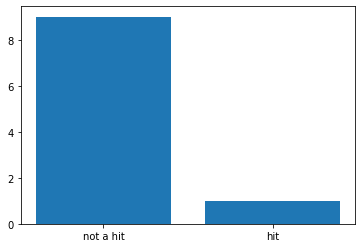

In [6]:
plt.bar(['not a hit', 'hit'], data_teste['y'].value_counts())
plt.show()

Até os meados do ano pudemos coletar informações e já identificamos os games que são hit e não hit.

In [7]:
data_teste = data_teste.drop(['Name', 'Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Count', 'User_Count', 'Developer'], axis=1)

Com as colunas reduzidas para as necessárias podemos checar quantas colunas não possuem dados:

In [8]:
data_teste.isnull().sum()

Platform        0
Genre           0
Publisher       0
Critic_Score    0
User_Score      0
Rating          0
y               0
dtype: int64

Como temos um conjunto muito pequeno de dados podemos colher as informações faltantes. A coleta foi manual e no final ficamos com o conjuto de dados completo.

In [9]:
data_teste = data_teste.dropna()

Os tratamentos nos dados foram todos refeitos conforme feito nos datasets de treinamento e validação. 

In [10]:
data_teste['User_Score'] = data_teste['User_Score'].apply(pd.to_numeric, errors='coerce')
data_teste['User_Score'] = data_teste['User_Score'].mask(np.isnan(data_teste["User_Score"]), data_teste['Critic_Score'] / 10.0)

Finalmente, convertemos valores categóricos para valores numéricos.

In [11]:
data_teste['y'] = data_teste['y'].apply(lambda y: 'yes' if y == True else 'no')
model_data_teste = pd.get_dummies(data_teste)

In [12]:
data_teste

,Platform,Genre,Publisher,Critic_Score,User_Score,Rating,y
0,PS5,Action,Bandai Namco Entertainment,96,7.6,M,yes
1,XB,Adventure,Warner Bros. Interactive,82,8.4,E10+,no
2,Switch,Role-Playing,Nintendo,83,8.2,E,no
3,PS5,Adventure,Sony (Corp),88,8.0,T,no
4,XB,Sports,Multiple Video Game Manufacturers,80,5.5,E,no
5,PS5,Racing,Sony (Corp),87,2.0,E,no
6,PS5,Action,Activision Blizzard (Corp),73,3.5,M,no
7,Switch,Action,Nintendo,85,8.8,E10+,no
8,XB,Sports,Electronic Arts,70,0.6,E,no
9,Switch,Racing,Nintendo,92,8.6,E,no


In [13]:
model_data_teste

,Critic_Score,User_Score,Platform_PS5,Platform_Switch,Platform_XB,Genre_Action,Genre_Adventure,Genre_Racing,Genre_Role-Playing,Genre_Sports,...,Publisher_Multiple Video Game Manufacturers,Publisher_Nintendo,Publisher_Sony (Corp),Publisher_Warner Bros. Interactive,Rating_E,Rating_E10+,Rating_M,Rating_T,y_no,y_yes
0,96,7.6,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,82,8.4,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
2,83,8.2,0,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,88,8.0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,1,0
4,80,5.5,0,0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
5,87,2.0,1,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
6,73,3.5,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
7,85,8.8,0,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
8,70,0.6,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
9,92,8.6,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0


XGBoost opera com dados no formato libSVM, com variaveis de atributos e variável alvo disponibilizados em argumentos distintos.

In [14]:
dump_svmlight_file(X=model_data_teste.drop(['y_no', 'y_yes'], axis=1), y=model_data_teste['y_yes'], f='test2022.libsvm')

---

## Verificação

Executaremos agora o processo preditivo nos dados de teste. Desta forma poderemos avaliar como o nosso modelo performa quando valida dados que ainda não foram utilizado no aprendizado de máquina.  Utilizaremos aqui o mesmo EndPoint que foi utilizado no treinamento.

In [15]:
endpoint_name = 'Endpoint2'

Executando o processo de predição abaixo poderemos comparar os que foram considerados 'hit'. No nosso grupo de teste temos como exemplo o primeiro Video-Game que está sendo amplamente vendido no ano de 2022 já alcançando mais do que 13 milhões de unidades vendidas.

In [16]:
runtime = boto3.client('runtime.sagemaker')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [17]:
def do_predict(data_teste, endpoint_name, content_type):
    payload = '\n'.join(data_teste)
    response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data_teste, batch_size, endpoint_name, content_type):
    items = len(data_teste)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)], endpoint_name, content_type)
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data_teste[offset:items], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [18]:
%%time
import json

with open('test2022.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100, endpoint_name, 'text/x-libsvm')

print ('\nerror rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

.
error rate=0.000000
CPU times: user 16.3 ms, sys: 451 µs, total: 16.8 ms
Wall time: 65.2 ms


In [19]:
pd.crosstab(index=np.array(labels), columns=np.array(preds))

col_0,0,1
row_0,,
0,9,0
1,0,1


Entre os 10 games incluidos no teste apenas um foi identificado como "hits" pelos dados coletados manualmente, o modelo identificou este caso corretamente, e para todos os outros casos o modelo considerou "not hits".  Podemos identificar nesta aplicação do modelo preditivo que a evolução do mercado de video-games requer que o modelo seja sempre aprimorado. Um exemplo disso é que novas plataformas são frequentemente lançadas e se tornam um atributo novo que requer mais datasets de treinamento para aprimoramento do modelo.
